In [2]:
import baltic as bt
from matplotlib import pyplot as plt
from collections import defaultdict
from matplotlib import cm
from numpy import linspace
%matplotlib inline
import json
import matplotlib.gridspec as gridspec
import math
from itertools import combinations
import pandas as pd

import numpy as np
import seaborn as sns
from pprint import pprint
import math
import sequtils as sue
from scipy.stats import linregress

In [4]:
dataset_name = 'thailand_s2'
out_path = '../../data/frequencies/thailand/stiffness2/'
tree_path = '../../data/frequencies/thailand/stiffness2/thailand_tree.json'
freqs_path = '../../data/frequencies/thailand/stiffness2/thailand_frequencies.json'
reference_path = '../../data/reference_seqs/genotype_refs_pyke2016.csv'
titer_path = '../../data/katzelnick2015/processed/genotypes_normalized.csv'

In [5]:
def assign_genotype_attr(tree, mrcas, trait='genotype'):
    ''' Takes the most basal node with each genotype annotation, 
    propagates the genotype assignment to its monophyletic descendents'''
    
    for k in tree.Objects: # remove old annotations
        k.traits = { key:value for key,value in k.traits.items()
                    if key not in (trait, '%s_mrca'%trait)}
        
    def annotate(genotype, node):
        node.traits['%s_mrca'%trait] = True
        node.traits[trait] = genotype
        for child in tree.traverse_tree(node, include_all=True):
            if trait in child.traits:
                if genotype != child.traits[trait]:
                    print 'ERROR: Overlapping %s trait %s and %s at index %s'%(trait, child.traits[trait], trait, child.index)
            child.traits[trait] = genotype
        
    for genotype, mrca in mrcas.items():
        if isinstance(mrca, list):
            for node in mrca:
                annotate(genotype, node)
        else:
            annotate(genotype, mrca)

    return tree

def load_tree_find_mrcas(path = tree_path):    
    '''Initially, genotype mrcas are as designated by augur.'''
    json_translation = {
        'name': 'strain',
        'height': 'xvalue',
    }
    tree = bt.loadJSON(path, json_translation) ## baltic Tree object
    mrcas = { node.traits['clade_name']: node 
             for node in tree.Objects if 'clade_name' in node.traits
            and node.traits['clade_name'] != 'DENV2_AMERICAN'}
    tree = assign_genotype_attr(tree, mrcas)
    return {'tree': tree, 'mrcas': mrcas, 'genotypes': list(set(mrcas.keys()))}

def annotate_references(tree, path=reference_path):
    refs = pd.read_csv(path, names=['serotype', 'genotype', 'year', 'accession', 'country', 'location'])
    refs['sero_geno'] = refs['serotype']+'_'+refs['genotype']
    ref_map = {acc:geno.upper() for (acc, geno) in zip(refs['accession'], refs['sero_geno'])}
    for k in tree.Objects:
        if k.branchType=='leaf' and k.traits['accession'] in ref_map:
            k.traits['reference_genotype'] = ref_map[k.traits['accession']]
    return tree

def init_genotypes_from_references(tree):
    genotype_refs = defaultdict(list)
    for k in tree.Objects:
        if 'reference_genotype' in k.traits:
            genotype_refs[k.traits['reference_genotype']].append(k)
    genotype_mrcas = { gt: tree.commonAncestor(tips, numName=True) for gt, tips in genotype_refs.items() }
    return genotype_mrcas

def assign_genotype_colors(genotypes):
    ''' {'denv2/asianI': viridis[0], ...}'''
    cmaps = [cm.Blues, cm.Greens, cm.Purples, cm.Reds]
    
    if genotypes[0].startswith('DENV'):
        color_dict = {}
        for i, sero in enumerate(['DENV1', 'DENV2', 'DENV3', 'DENV4']):
            cmap = cmaps[i]
            color_dict[sero] = cmap(.5)
            geno = sorted([ g for g in genotypes if g.startswith(sero)])
            cm_subsection = linspace(0.25, 0.75,len(geno))
            colors = [ cmap(g) for g in cm_subsection]
            color_dict.update({g:color for (g,color) in zip(geno, colors)})

    else:
        cmap = cmaps[1]
        genotypes.sort()
        cm_subsection = linspace(0.25, 0.75,len(genotypes))
        colors = [ cmap(g) for g in cm_subsection]
        color_dict = {g:color for (g,color) in zip(genotypes, colors)}

    return color_dict

In [6]:
#### Parse the tree & assign genotypes

tmp = load_tree_find_mrcas()

# bt.tree with k.traits['genotype'] initially assigned by augur-inferred clade_name trait
tree = tmp['tree']
tree = annotate_references(tree)

# {'DENV2_AMERICAN': <baltic node>}
mrcas = tmp['mrcas']
if mrcas == {}:
    mrcas = init_genotypes_from_references(tree)

# ['denv2_american', 'denv1_I', ...]
genotypes = mrcas.keys()

# {'denv2_american': color}
colors = assign_genotype_colors(genotypes)


Tree height: 0.313630
Tree length: 2.354380
annotations present

Numbers of objects in tree: 872 (415 nodes and 457 leaves)



In [7]:
def load_all_frequencies(mrcas, path):
    '''
    {'south_america': 
            {0: [ 0.1, 0.4, 0.23, ....]},
        }, 
    'pivots': [1900, 1901, ...]
    'genotypes': set('DENV2_AMERICAN', ...)}
    '''    
    raw_frequencies = json.load(open(path, 'r')) ## {'southeast_asia_clade:179':[0.1, 0.23, ...]}
    pivots = raw_frequencies.pop('pivots') # [1917., 1918., ...]
    
    regional_clade_frequencies = defaultdict(dict) ## {'global': {'0': [0.1, 0.23, ...] } }
    for label, freqs in raw_frequencies.items():
        if 'clade:' not in label: #south_america_II, africa_denv4_II
            split_label = label.split('_')

            if 'DENV' in label:
                region = '_'.join(split_label[:-2])
                clade = '_'.join(split_label[-2:])
            else:
                region = '_'.join(split_label[:-1])
                clade = '_'.join(split_label[-1:])
            try:
                clade = mrcas[clade].traits['clade']
            except:
                continue
                
        else: # 'global_clade:0'
            region, clade = label.split('_clade:')
            
        clade = int(clade) # the tree uses integers for clade indices
        regional_clade_frequencies[region][clade] = freqs 
        
    return {'frequencies': dict(regional_clade_frequencies), 
            'pivots': pivots }

def get_genotype_frequencies(mrcas, frequencies):
    genotype_frequencies = defaultdict(dict)
    
    for genotype, mrca in mrcas.items():
        if isinstance(mrca, bt.node):
            mrca_clade = mrca.traits['clade']
            genotype_frequencies[genotype] = frequencies[mrca_clade] 
            
        elif isinstance(mrca, list):
            mrca_clades = [m.traits['clade'] for m in mrca]
            clade_frequencies = [frequencies[c] for c in mrca_clades]
            total_genotype_frequency = [sum(i) for i in zip(*clade_frequencies)]
            genotype_frequencies[genotype] = total_genotype_frequency
            
    return dict(genotype_frequencies)

def make_dataframe(genotype_frequencies, pivots, mindate=1970.):
    ''' dataframe with genotypes as columns, pivots as index, region-specific frequencies as values'''
    df = pd.DataFrame(genotype_frequencies, index=pivots)
    df = df.loc[df.index[df.index >= mindate]]
    return df

In [8]:
tree_string = tree.toString(traits=['clade', 'reference_genotype', 'genotype'], numName=True, nexus=True)
open('./tmp_genotype_annotation.nexus', 'w').write(tree_string)


################################
'''
Now open tmp_genotype_annotation.nexus in figtree, select:
appearance > colorby > reference_genotype
tip labels > reference_genotype
branch labels > clade

fill in the clade # for each genotype MRCA below, 
then run the cell to update the attributes in the tree and pull the correct frequency vectors
'''
#################################
pass

In [23]:
serotype_mrcas = {
            'DENV1': ,
         'DENV2': , 
         'DENV3': ,
         'DENV4':}

mrcas['DENV1_I'] = 
mrcas['DENV1_II'] = 
mrcas['DENV1_IV'] = 
mrcas['DENV1_V'] = 
# mrcas['DENV1_III'] = None

mrcas['DENV3_I'] = 
mrcas['DENV3_II'] = 
mrcas['DENV3_III'] = 
mrcas['DENV3_V'] = 

mrcas['DENV4_SYLVATIC'] = 
mrcas['DENV4_I'] = 
mrcas['DENV4_II'] = 

mrcas['DENV2_AMERICAN'] = 3
mrcas['DENV2_ASIANII'] = 497
mrcas['DENV2_COSMOPOLITAN'] = 117
mrcas['DENV2_ASIANI'] = 543
mrcas['DENV2_SYLVATIC'] = 4
mrcas['DENV2_ASIANAMERICAN'] = 638

def update_mrcas(mrcas=mrcas, tree=tree):
    
    def lookup_node(genotype, clade, tree):
        try:
            return [k for k in tree.nodes if k.traits['clade'] == clade][0]
        except:
            print '%s mrca not found'%(genotype)
            return None
        
    for genotype, mrca in mrcas.items():
        if isinstance(mrca, int) or mrca == None:
            node = lookup_node(genotype, mrca, tree)
            if node:
                mrcas[genotype] = node
            else:
                del mrcas[genotype]
                
        elif isinstance(mrca, list):
            nodes = [lookup_node(genotype, node, tree) for node in mrca]
            nodes = [n for n in nodes if n != None]
            if nodes != []:
                mrcas[genotype] = nodes
            else:
                print 'No MRCAs found for genotype %s'%genotype
                del mrcas[genotype]
    return mrcas

mrcas = update_mrcas(mrcas, tree)
tree = assign_genotype_attr(tree, mrcas)
serotype_mrcas = update_mrcas(serotype_mrcas)
tree= assign_genotype_attr(tree, serotype_mrcas, 'serotype')
# ['denv2_american', 'denv1_I', ...]
genotypes = mrcas.keys()
# {'denv2_american': color}
colors = assign_genotype_colors(genotypes)

In [24]:
strain_genotypes = open('../../data/titer-model/strain_genotypes.tsv', 'w')
for k in tree.leaves:
    try:
        strain_genotypes.write(k.traits['strain']+'\t'+k.traits['genotype']+'\n')
    except:
        continue
strain_genotypes.close()

In [25]:
def load_all_frequencies(mrcas, path):
    '''
    {'south_america': 
            {0: [ 0.1, 0.4, 0.23, ....]},
        }, 
    'pivots': [1900, 1901, ...]
    'genotypes': set('DENV2_AMERICAN', ...)}
    '''    
    raw_frequencies = json.load(open(path, 'r')) ## {'southeast_asia_clade:179':[0.1, 0.23, ...]}
    pivots = raw_frequencies.pop('pivots') # [1917., 1918., ...]
    
    regional_clade_frequencies = defaultdict(dict) ## {'global': {'0': [0.1, 0.23, ...] } }
    for label, freqs in raw_frequencies.items():
        if 'clade:' not in label: #south_america_II, africa_denv4_II
            split_label = label.split('_')

            if 'DENV' in label:
                region = '_'.join(split_label[:-2])
                clade = '_'.join(split_label[-2:])
            else:
                region = '_'.join(split_label[:-1])
                clade = '_'.join(split_label[-1:])
            try:
                clade = mrcas[clade].traits['clade']
            except:
                continue
                
        else: # 'global_clade:0'
            region, clade = label.split('_clade:')
            
        clade = int(clade) # the tree uses integers for clade indices
        regional_clade_frequencies[region][clade] = freqs 
        
    return {'frequencies': dict(regional_clade_frequencies), 
            'pivots': pivots }

def get_genotype_frequencies(mrcas, frequencies):
    genotype_frequencies = defaultdict(dict)
    
    for genotype, mrca in mrcas.items():
        if isinstance(mrca, bt.node):
            mrca_clade = mrca.traits['clade']
            genotype_frequencies[genotype] = frequencies[mrca_clade] 
            
        elif isinstance(mrca, list):
            mrca_clades = [m.traits['clade'] for m in mrca]
            clade_frequencies = [frequencies[c] for c in mrca_clades]
            total_genotype_frequency = [sum(i) for i in zip(*clade_frequencies)]
            genotype_frequencies[genotype] = total_genotype_frequency
            
    return dict(genotype_frequencies)

def make_dataframe(genotype_frequencies, pivots, mindate=1970.):
    ''' dataframe with genotypes as columns, pivots as index, region-specific frequencies as values'''
    genotype_frequencies = {k:v for k,v in genotype_frequencies.items() if 'SYLVATIC' not in k}
    df = pd.DataFrame(genotype_frequencies, index=pivots)
    df = df.loc[df.index[df.index >= mindate]]
    return df

In [26]:
tmp = load_all_frequencies(mrcas, freqs_path)
pivots = tmp['pivots']
genotype_frequencies = {region: get_genotype_frequencies(mrcas, freqs) for region, freqs in tmp['frequencies'].items()}
genotype_frequencies = {region: make_dataframe(freqs, pivots) for region, freqs in genotype_frequencies.items()}


In [27]:
tmp = load_all_frequencies(serotype_mrcas, freqs_path)
pivots = tmp['pivots']
serotype_frequencies = {region: get_genotype_frequencies(serotype_mrcas, freqs) for region, freqs in tmp['frequencies'].items()}
serotype_frequencies = {region: make_dataframe(freqs, pivots) for region, freqs in serotype_frequencies.items()}

In [28]:
def plot_region_frequencies(freqs, region, date_range = None, pivots=pivots):
    plt.title(region)
    plt.xlabel('Year')
    plt.ylabel('Genotype Frequency')

    if date_range:
        pivots = [i for i in pivots if i > date_range[0] and i < date_range[1]]
        freqs = freqs.ix[pivots]
    
    for genotype, freqs in freqs.iteritems():
        plt.plot(pivots, freqs, color=colors[genotype], label=genotype)   
    
def plot_tree(tree, labels=False, colorby='genotype'):
    branchWidth=2 ## default branch width
    ll = tree

    plt.yticks(size=0)
    
    for k in ll.Objects: ## iterate over objects in tree
        x=k.x ## or use absolute time instead
        y=k.y ## get y position from .drawTree that was run earlier, but could be anything else

        xp=k.parent.x ## get x position of current object's parent
        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
        if xp==None:
            xp=x
        c = colors[k.traits[colorby]] if k.traits.has_key(colorby) else 'gray'
            
        if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
            s=50 ## tip size can be fixed
            s=50-30*k.height/ll.treeHeight
            
            plt.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
            plt.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
                        
        elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
            plt.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color=c,ls='-',zorder=9)
            
        plt.plot([xp,x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9)
        
    x0,x1 = plt.xlim()
    plt.xlim((x0, x1*1.1))


def plot_frequencies_and_tree(save=False, ofilename = None, colorby='genotype', frequencies=genotype_frequencies,
                              title='Dengue Genotypes'):
    sns.set(style='whitegrid', font_scale = 1.3)
    fig = plt.figure(figsize=(11,8.5))
    gs = gridspec.GridSpec(3,3, width_ratios=[1,1,2], )
    
    globe = plt.subplot(gs[0, :-1])
    plot_region_frequencies(frequencies['global'], 'Global', date_range=[1985., 2015.])
    plt.legend(loc=(2.,-2.), title=title, fontsize='medium')
    globe.set_ylim([0, 1])

    if len(frequencies.keys()) > 1:
        south_america = plt.subplot(gs[1,:-1])
        plot_region_frequencies(frequencies['south_america'], 'South America',date_range=[1985., 2015.])
        south_america.set_ylim([0, 1])

        southeast_asia = plt.subplot(gs[2, :-1])
        plot_region_frequencies(frequencies['southeast_asia'], 'Southeast Asia', date_range=[1985., 2014.])
        southeast_asia.set_ylim([0, 1])
        
    sns.set(style = 'white', font_scale = 1.3)
    treeplot = plt.subplot(gs[:,-1])
    plot_tree(tree, colorby=colorby)
        
    plt.tight_layout()
    
    if save==True:
        plt.savefig(ofilename, dpi=400, bbox_inches='tight')
    else:    
        plt.show()
    
def plot_subtrees(tree, labels = False):
    sns.set(style='whitegrid', font_scale=1.3)
    figure = plt.figure(figsize=(10,50))
    serotypes = ['DENV1', 'DENV2', 'DENV3', 'DENV4']
    serotype_tips = { sero: [k for k in tree.Objects if k.branchType=='leaf' and k.numName.startswith(sero)] for sero in serotypes}
    serotype_mrcas = []
    
    for sero in serotypes:
        try:
            serotype_mrcas.append((sero, tree.commonAncestor(serotype_tips[sero], numName=True)))
        except Exception as e:
            print sero
            print e
            continue
    
    for i, (serotype, mrca) in enumerate(serotype_mrcas, start=1):
        plt.subplot(4, 1,i)
        subtree = tree.subtree(mrca)
        plot_tree(subtree, labels=labels)
    plt.tight_layout()
    plt.show()

/Users/Sidney/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


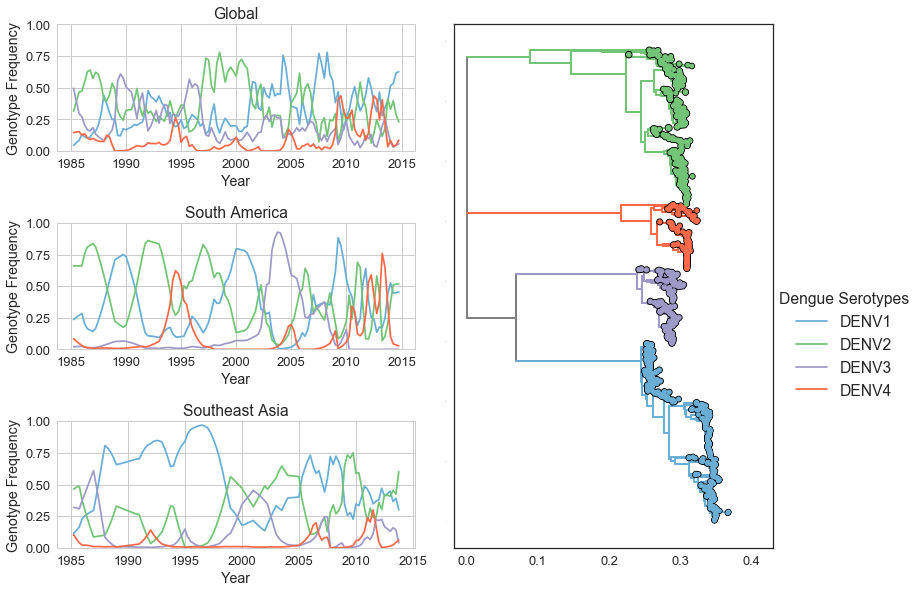

In [29]:
plot_frequencies_and_tree(save=True, ofilename='../../slides/epidemics2017/figures/png/serotype_frequencies.png', 
                          colorby='serotype', title='Dengue Serotypes', frequencies=serotype_frequencies)

/Users/Sidney/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


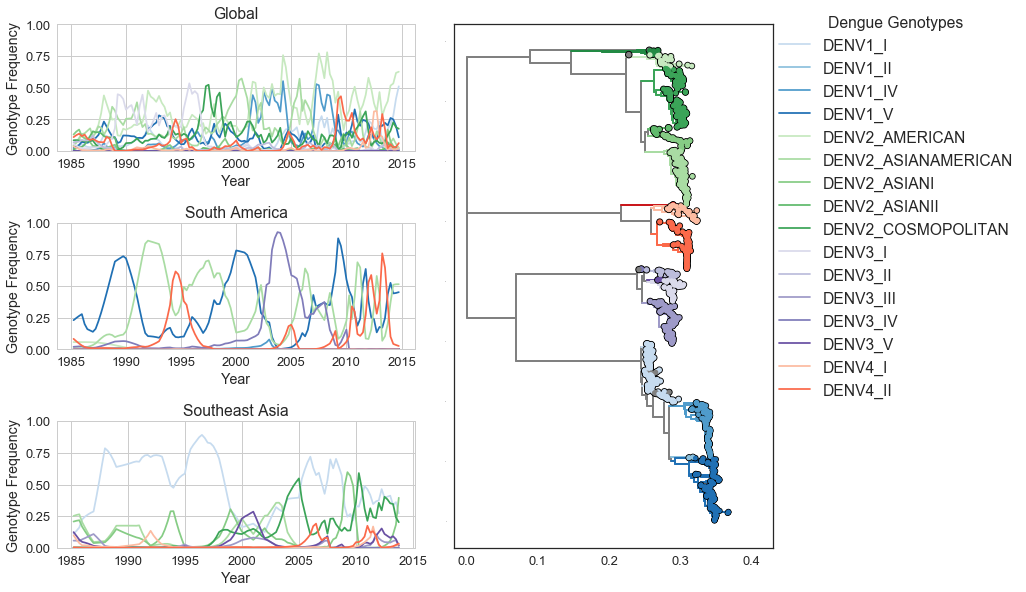

In [30]:
plot_frequencies_and_tree(save=True, ofilename='../../slides/epidemics2017/figures/png/genotype_frequencies.png', 
                          colorby='genotype', title='Dengue Genotypes', frequencies=genotype_frequencies)

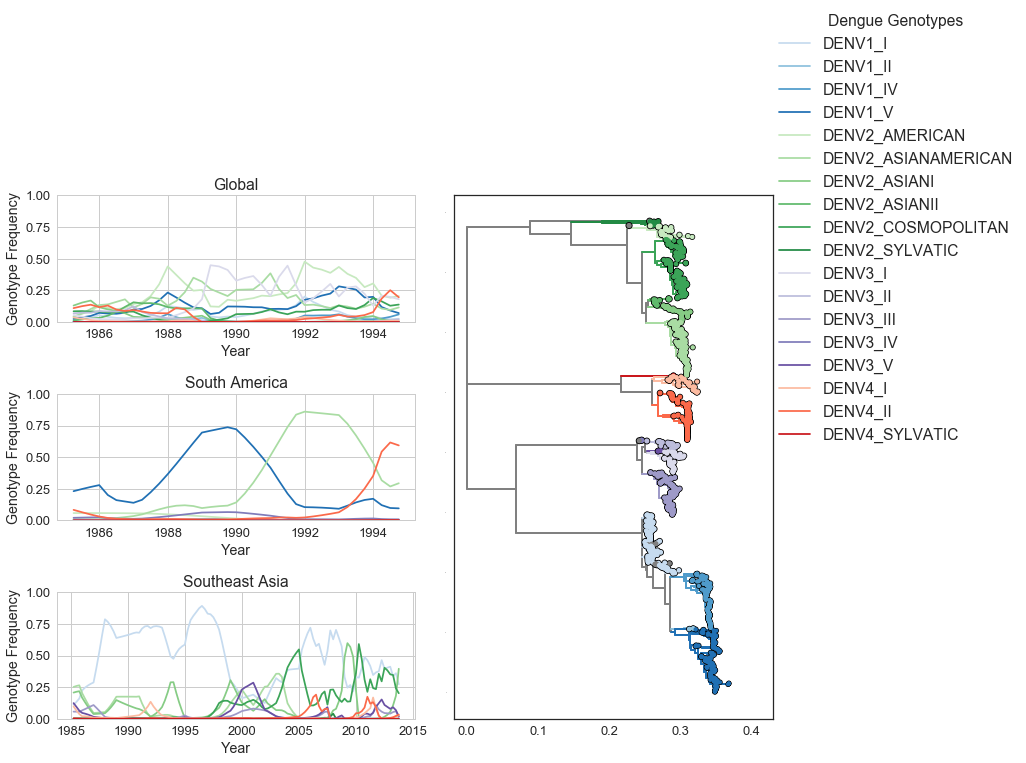

In [14]:
def export(out_path=out_path, dataset_name=dataset_name, tree=tree, frequencies=frequencies):
    plot_frequencies_and_tree(save=True, ofilename=out_path+'/'+dataset_name+'_frequencies_tree.png')
    tree_string = tree.toString(traits=['clade', 'reference_genotype', 'genotype'], numName=True, nexus=True)
    open(out_path+'/'+dataset_name+'_gtAnnotated_tree.nexus', 'w').write(tree_string)

    if len(frequencies) == 1:
        frequencies.values()[0].to_csv(out_path+'/'+dataset_name+'_frequencies.csv')
    else:
        for region, df in frequencies.items():
            df.to_csv(out_path+'/'+dataset_name+'_'+region+'_frequencies.csv')

export()
    